In [19]:
import tensorflow as tf
from tensorflow.keras import layers,optimizers,losses
from tensorflow.keras import Sequential,Model,Input
from tensorflow.data import Dataset
from tensorflow.keras import callbacks
import numpy as np
import matplotlib.pyplot as plt
import cv2
import copy
import time

In [2]:
def image_pooling(image, new_width, new_height):
    return cv2.resize(image, (new_height, new_width), interpolation=cv2.INTER_AREA)

def computeRollingVarianceSum(mean, prev_mean, cur, last):
    return  (cur - prev_mean) * (cur - mean) - (last - prev_mean) * (last - mean)

def swapPositions(li, pos1, pos2):
    li[pos1],li[pos2] = li[pos2],li[pos1]
    return li
def push_down(li):
    for i in range(len(li)-1):
        swapPositions(li, i, i+1)
     #list[-1] is untouched
    return li

In [3]:
def getVariances(video_path, frame_width=128, frame_height=128, target_frame_width=28, target_frame_height=28):
    """
    video_path is the file path to the input video
    Uses functions in the github

    Returns:
    (diff_variances, input_variances)
    """

    rotation_frequency = 150  # enter in revolution per second

    # say the input frames are periodic and can be described by a*sin(bx+c)+d
    # its derivative is a*b*cos(bx+c)
    # its second derivative is -a*b*b*sin(bx+c)
    # so f(x)-f'(x-pi/(2*b))/b should be constant so should f(x)+f"(x)/b/b
    # the second is much better because the first involves a phase shift which
    # requires access to data taken pi/(2*b) ago and will thus lower the processing
    # speed or accuracy.
    # the key is to know b, which is equal to frequency*2pi
    frequency_const = rotation_frequency*2*np.pi

    num_frame = 5

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(5)
    total_frames = int(cap.get(7))-num_frame+1
    print('Video loaded with', total_frames,'frames')

    input_frame = [np.zeros((target_frame_width,target_frame_height,3),dtype=np.float32) for i in range(num_frame+1)]
    input_mean = np.zeros((target_frame_width,target_frame_height,3),dtype=np.float32)
    input_var_sum = np.zeros((target_frame_width,target_frame_height,3),dtype=np.float32)

    derivative1 = [np.zeros((target_frame_width,target_frame_height,3),dtype=np.float32) for i in range(num_frame)]
    derivative2 = [np.zeros((target_frame_width,target_frame_height,3),dtype=np.float32) for i in range(num_frame-1)]

    diff = [np.zeros((target_frame_width,target_frame_height,3),dtype=np.float32) for i in range(num_frame-1)]
    diff_mean = np.zeros((target_frame_width,target_frame_height,3),dtype=np.float32)
    diff_var_sum = np.zeros((target_frame_width,target_frame_height,3),dtype=np.float32)

    input_vars = np.zeros((int(cap.get(7)),target_frame_width,target_frame_height,3),dtype=np.float32)
    diff_vars = np.zeros((int(cap.get(7)),target_frame_width,target_frame_height,3),dtype=np.float32)
    
    orig_video = np.zeros((int(cap.get(7)),target_frame_width,target_frame_height,3),dtype=np.float32)
    deltaTime = 1.0/fps
    for i in range(int(cap.get(7))):
        ret, frame = cap.read()
        assert ret
        prev_input_mean = copy.deepcopy(input_mean)
        prev_diff_mean = copy.deepcopy(diff_mean)

        input_frame = push_down(input_frame)
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        frame = image_pooling(frame, target_frame_width, target_frame_height)
        orig_video[i] = frame
        del_input_frame = copy.deepcopy(input_frame[-1])
        input_frame[-1]=frame
        input_mean = (input_mean*(num_frame+1) + frame - del_input_frame)/(num_frame+1)
        # 1 2 3 3 4 6
        #  1 2 3 4 5
        #   3 4 5 6
        derivative1 = push_down(derivative1)
        derivative1[-1]=(input_frame[-1]-input_frame[-2])/deltaTime
        derivative2 = push_down(derivative2)
        derivative2[-1]=(derivative1[-1]-derivative1[-2])/deltaTime

        diff = push_down(diff)
        del_diff = copy.deepcopy(diff[-1])
        diff[-1] = input_frame[-2]+derivative2[-1]/(frequency_const**2)
        diff_mean = (diff_mean*(num_frame-1) + diff[-1] - del_diff)/(num_frame-1)


        input_var_sum += computeRollingVarianceSum(input_mean, prev_input_mean, input_frame[-1], del_input_frame)

        diff_var_sum += computeRollingVarianceSum(diff_mean, prev_diff_mean, diff[-1], del_diff)

        input_var_sum2 = np.var(np.asarray(input_frame), axis=0)
        diff_var_sum2 = np.var(np.asarray(diff), axis=0)

        input_vars[i] = input_var_sum/(num_frame+1)
        diff_vars[i] = diff_var_sum/(num_frame-1)
    return diff_vars, input_vars, orig_video



In [24]:
diff1, input1, orig_video1 = getVariances('outdoor_window.avi')
positive_data = (np.concatenate([input1,diff1],axis=-1), orig_video1)

Video loaded with 873 frames


In [25]:
diff2, input2, orig_video2 = getVariances('indoor.avi')
negative_data = (np.concatenate([input2,diff2],axis=-1), orig_video2)

Video loaded with 897 frames


In [36]:
positive_data = (positive_data[0][6:],positive_data[1][6:])
negative_data = (negative_data[0][6:],negative_data[1][6:])

In [52]:
data = (np.concatenate([positive_data[0],negative_data[0]],axis=0),np.concatenate([positive_data[1],negative_data[1]],axis=0))
results = np.concatenate([np.ones((positive_data[0].shape[0],28,28,1)),np.zeros((negative_data[0].shape[0],28,28,1))],axis=0)
permute = np.random.permutation(data[0].shape[0])
data = (data[0][permute],data[1][permute])
results = results[permute]

In [44]:
windowCNN = Sequential([
    layers.Conv2D(16,(9,9),padding='same',activation='relu'),
    layers.Conv2D(32,(6,6),padding='same',activation='relu'),
    layers.Conv2D(32,(3,3),padding='same',activation='relu'),
    layers.Conv2D(32,(1,1),activation='relu')
])

In [45]:
varianceCNN = Sequential([
    layers.Conv2D(16,(1,1),activation='relu'),
    layers.Conv2D(32,(1,1),activation='relu'),
])

In [46]:
toplevelCNN = Sequential([
    layers.Conv2D(64,(1,1),activation='relu'),
    layers.Conv2D(16,(1,1),activation='relu'),
    layers.Conv2D(1,(1,1),activation='sigmoid')
])

In [59]:
input_img = Input(shape=(None,None,3))
input_var = Input(shape=(None,None,6))
img_feature = windowCNN(input_img)
var_feature = varianceCNN(input_var)
total_feature = layers.concatenate([img_feature,var_feature])
total_feature = toplevelCNN(total_feature)
totalModel = Model(inputs=[input_var,input_img],outputs=[total_feature])

In [60]:
totalModel.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, None, None, 3 32672       input_9[0][0]                    
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, None, None, 3 656         input_10[0][0]                   
____________________________________________________________________________________________

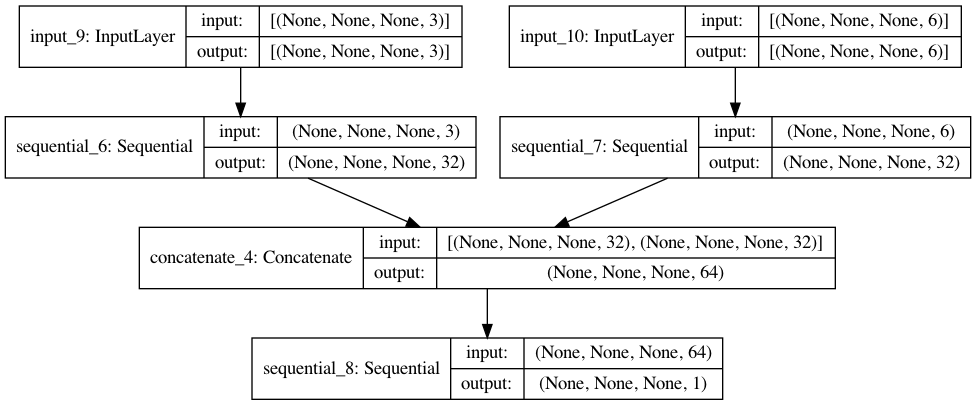

In [61]:
tf.keras.utils.plot_model(totalModel,to_file='advanced_model.png',show_shapes=True)

In [62]:
totalModel.compile(optimizer=optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['acc'])

In [65]:
totalModel.fit(data,results,epochs=5,batch_size=64,validation_split=0.3)

Epoch 1/5
19/19 [==============================] - 3s 163ms/step - loss: 0.0057 - acc: 0.9986 - val_loss: 0.0051 - val_acc: 0.9987
Epoch 2/5
19/19 [==============================] - 3s 160ms/step - loss: 0.0042 - acc: 0.9990 - val_loss: 0.0035 - val_acc: 0.9990
Epoch 3/5
19/19 [==============================] - 3s 166ms/step - loss: 0.0035 - acc: 0.9991 - val_loss: 0.0031 - val_acc: 0.9993
Epoch 4/5
19/19 [==============================] - 3s 183ms/step - loss: 0.0030 - acc: 0.9992 - val_loss: 0.0026 - val_acc: 0.9992
Epoch 5/5
19/19 [==============================] - 3s 170ms/step - loss: 0.0025 - acc: 0.9994 - val_loss: 0.0028 - val_acc: 0.9994


In [66]:
diff3, input3, orig_video3 = getVariances('indoor_window.mov')
test_data = (np.concatenate([input3,diff3],axis=-1), orig_video3)

Video loaded with 802 frames


In [67]:
totalModel.evaluate(test_data,np.ones((test_data[0].shape[0],28,28,1)))

26/26 [==============================] - 0s 18ms/step - loss: 10.9589 - acc: 0.3595


[10.958945274353027, 0.35951662063598633]